# Example processing: Intra-train heating
This uses a simplified version of the process_dssc_module function:

* frames are not grouped (e.g., in 'pumped', 'unpumped' or 'dark' frames)
* no selection of trains and/or pulses is done

The purpose of this analysis is to check how robust the diffraction signal is with respect to the repeated heat and radiation load from high repetition-rate pump-probe runs. Thus, we average over all trains within the run, but keep all individual pulses.

In [1]:
import karabo_data as kd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import multiprocessing
from tqdm.auto import tqdm
from time import strftime
from matplotlib.colors import LogNorm, BoundaryNorm
import os
import dssc_process as dp

kd.__version__

'0.6.2'

In [2]:
%matplotlib inline

In [3]:
# make sure subfolders exist
for f in ['tmp', 'images', 'processed_runs']:
    if not os.path.isdir(f):
        os.mkdir(f)

## setup run information and index non-DSSC data

In [4]:
%%time

# basic run information
proposal = 2212
run_nr = 89
is_dark = False

# index non-DSSC data
run = dp.load_run_selective(proposal, run_nr, exclude='DSSC')

CPU times: user 107 ms, sys: 80.4 ms, total: 188 ms
Wall time: 2.5 s


## load XGM (but no filtering/ thresholding)

In [5]:
if not is_dark:
    xgm = dp.load_xgm(run, print_info=True)

SASE3 bunches per train: 75


## plot XGM

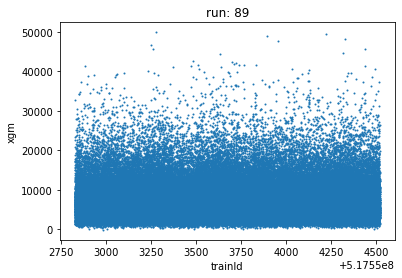

In [6]:
if not is_dark:
    fig, ax1 = plt.subplots(nrows=1, sharex=True)

    # ax1.plot(scan.xgm.mean('dim_0'), label='pumped')
    ax1.plot(xgm.trainId, xgm, 'o', c='C0', ms=1)
    ax1.set_ylabel('xgm')
    ax1.set_xlabel('trainId')

    ax1.set_title(f'run: {run_nr}')

    tstamp = strftime('%y%m%d_%H%M')
    fig.savefig(f'images/run{run_nr}_xgm_{tstamp}.png', dpi=200)

## calculate chunksize
This is a conservative estimate for the maximum number of trains to process simultaneously without using more than "max_GB" gigabytes of memory.

In [8]:
max_GB = 300
fpt = dp.load_dssc_info(proposal, run_nr)['frames_per_train']

# max_GB / (8byte * 16modules * 128px * 512px * N_pulses)
chunksize = int(max_GB * 128 // fpt)
chunksize = min(512, chunksize)  # more than 512 trains doesn't seem to give any performance benefit
print('processing', chunksize, 'trains per chunk')

processing 512 trains per chunk


## create joblist for multiprocessing

In [9]:
jobs = []
for m in range(16):
    jobs.append(dict(
        proposal=proposal,
        run_nr=run_nr,
        module=m,
        chunksize=chunksize,
        fpt=fpt,
    ))

## create multiprocessing pool and execute

In [10]:
%%time

timestamp = strftime('%X')
print(f'start time: {timestamp}')

with multiprocessing.Pool(16) as pool:
    module_data = pool.map(dp.process_intra_train, jobs)
    
print('finished:', strftime('%X'))

module_data = xr.concat(module_data, dim='module')
module_data['run'] = run_nr
module_data = module_data.transpose('pulse', 'module', 'x', 'y')

start time: 10:33:15


100%|██████████| 4/4 [01:11<00:00, 17.30s/it]

finished: 10:34:33
CPU times: user 637 ms, sys: 1.2 s, total: 1.83 s
Wall time: 1min 18s


## merge processed data with scan variable and normalization data

In [11]:
if not is_dark:
    xgm['pulse'] = np.arange(fpt, dtype=int)
    xgm = xgm.mean('trainId')
    xgm.name = 'xgm'
    module_data = xr.merge([module_data, xgm])

## save to hdf5

In [12]:
overwrite = False

save_folder = './processed_runs/'
prefix = ''

if is_dark:
    fname = f'{prefix}run{run_nr}.h5'  # no scan
else:
    fname = f'{prefix}run{run_nr}_by-pulse.h5'  # run with delay scan (change for other scan types!)


save_path = os.path.join(save_folder, fname)
file_exists = os.path.isfile(save_path)

if (not file_exists) or (file_exists and overwrite):
    if file_exists:
        os.remove(save_path)
    module_data.to_netcdf(save_path, group='data')
    os.chmod(os.path.join(save_folder, fname), 664)
    print('saving: ', save_path)
else:
    print('file', save_path, 'exists and overwrite is False')

saving:  ./processed_runs/run89_by-pulse.h5
